# AUC-ROC Curve Visualization for LDAP Model

This notebook visualizes the ROC curves for the joint VGAE-LDAGM model across 5-fold cross-validation.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

# Import from main.py
from main import JointVGAE_LDAGM, JointDataset, joint_train, joint_test
import config

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Configuration and Setup


In [6]:
# Configuration
dataset = config.DATASET

# Device selection
if config.DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
elif config.DEVICE == "mps" and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    if config.DEVICE in ["cuda", "mps"]:
        print(f"Warning: {config.DEVICE} not available, falling back to CPU")

print(f"Using device: {device}")
print(f"Dataset: {dataset}")
print(f"Total folds: {config.TOTAL_FOLDS}")


Using device: cuda
Dataset: dataset2
Total folds: 5


## Run 5-Fold Cross-Validation and Collect ROC Data


In [8]:
# Storage for ROC curves data
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_fold_results = []

print(f"Starting 5-fold cross-validation for {dataset}...\n")

for fold in range(config.TOTAL_FOLDS):
    print(f"\n{'='*50}")
    print(f"Processing Fold {fold + 1}/5")
    print(f"{'='*50}")
    
    # Load data indices
    positive5foldsidx = np.load(
        f"./our_dataset/{dataset}/index/positive5foldsidx.npy",
        allow_pickle=True,
    )
    negative5foldsidx = np.load(
        f"./our_dataset/{dataset}/index/negative5foldsidx.npy",
        allow_pickle=True,
    )
    positive_ij = np.load(f"./our_dataset/{dataset}/index/positive_ij.npy")
    negative_ij = np.load(f"./our_dataset/{dataset}/index/negative_ij.npy")
    
    train_positive_ij = positive_ij[positive5foldsidx[fold]["train"]]
    train_negative_ij = negative_ij[negative5foldsidx[fold]["train"]]
    test_positive_ij = positive_ij[positive5foldsidx[fold]["test"]]
    test_negative_ij = negative_ij[negative5foldsidx[fold]["test"]]

    # Load similarity matrices
    di_semantic_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/di_semantic_similarity.npy")
    di_gip_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/di_gip_similarity_fold_{fold+1}.npy")
    lnc_gip_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/lnc_gip_similarity_fold_{fold+1}.npy")
    lnc_func_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/lnc_func_similarity_fold_{fold+1}.npy")
    mi_gip_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/mi_gip_similarity.npy")
    mi_func_similarity = np.load(f"./our_dataset/{dataset}/multi_similarities/mi_func_similarity.npy")
    
    # Load interaction matrices
    lnc_di = pd.read_csv(f'./our_dataset/{dataset}/interaction/lnc_di.csv')
    lnc_di.set_index('0', inplace=True)
    lnc_di = lnc_di.values
    lnc_di_copy = copy.copy(lnc_di)
    
    lnc_mi = pd.read_csv(f'./our_dataset/{dataset}/interaction/lnc_mi.csv', index_col='0').values
    mi_di = pd.read_csv(f'./our_dataset/{dataset}/interaction/mi_di.csv')
    mi_di.set_index('0', inplace=True)
    mi_di = mi_di.values
    
    # Get dimensions
    num_diseases = di_semantic_similarity.shape[0]
    num_lnc = lnc_gip_similarity.shape[0]
    num_mi = mi_gip_similarity.shape[0]
    lncRNALen = num_lnc
    
    # Remove test edges from training adjacency matrix
    for ij in positive_ij[positive5foldsidx[fold]['test']]:
        lnc_di_copy[ij[0], ij[1] - lncRNALen] = 0
    
    # Create adjacency matrices for each entity type
    disease_adjacency_matrices = [
        torch.tensor(di_semantic_similarity, dtype=torch.float32).to(device), 
        torch.tensor(di_gip_similarity, dtype=torch.float32).to(device)
    ]
    lnaRNA_adjacency_matrices = [
        torch.tensor(lnc_gip_similarity, dtype=torch.float32).to(device), 
        torch.tensor(lnc_func_similarity, dtype=torch.float32).to(device)
    ]
    miRNA_adjacency_matrices = [
        torch.tensor(mi_gip_similarity, dtype=torch.float32).to(device), 
        torch.tensor(mi_func_similarity, dtype=torch.float32).to(device)
    ]
    
    # Create datasets
    train_dataset = JointDataset(train_positive_ij, train_negative_ij, "train", dataset)
    test_dataset = JointDataset(test_positive_ij, test_negative_ij, "test", dataset)
    
    # Prepare multi-view data structure
    multi_view_data = {
        'disease': disease_adjacency_matrices,
        'lnc': lnaRNA_adjacency_matrices,
        'mi': miRNA_adjacency_matrices
    }
    
    # Prepare interaction matrices as tensors
    lnc_di_tensor = torch.tensor(lnc_di_copy, dtype=torch.float32).to(device)
    lnc_mi_tensor = torch.tensor(lnc_mi, dtype=torch.float32).to(device)
    mi_di_tensor = torch.tensor(mi_di, dtype=torch.float32).to(device)
    
    print(f"Training fold {fold + 1}...")
    
    # Joint training
    trained_model, loss_history = joint_train(
        num_lnc=num_lnc,
        num_diseases=num_diseases,
        num_mi=num_mi,
        train_dataset=train_dataset,
        multi_view_data=multi_view_data,
        lnc_di_interaction=lnc_di_tensor,
        lnc_mi_interaction=lnc_mi_tensor,
        mi_di_interaction=mi_di_tensor,
        fold=fold,
        device=device
    )
    
    print(f"Testing fold {fold + 1}...")
    
    # Testing
    test_labels, test_predictions = joint_test(
        model=trained_model,
        test_dataset=test_dataset,
        multi_view_data=multi_view_data,
        lnc_di_interaction=lnc_di_tensor,
        lnc_mi_interaction=lnc_mi_tensor,
        mi_di_interaction=mi_di_tensor,
        fold=fold,
        batch_size=config.BATCH_SIZE,
        device=device
    )
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
    roc_auc = auc(fpr, tpr)
    
    # Store results
    aucs.append(roc_auc)
    fpr_unique, idx = np.unique(fpr, return_index=True)
    tpr_unique = tpr[idx]
    
    interp_tpr = np.interp(mean_fpr, fpr_unique, tpr_unique)
    interp_tpr[0] = 0.0
    interp_tpr[-1] = 1.0
    tprs.append(interp_tpr)
    
    # Store fold info
    all_fold_results.append({
        'fold': fold + 1,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'thresholds': thresholds
    })
    
    print(f"Fold {fold + 1} AUC: {roc_auc:.4f}")

print("\n" + "="*50)
print("All folds completed!")
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print("="*50)


Starting 5-fold cross-validation for dataset2...


Processing Fold 1/5
dataset2 train dataset loaded with 6132 samples
dataset2 test dataset loaded with 1534 samples
Training fold 1...
Testing fold 1...
Fold 1 AUC: 0.9631

Processing Fold 2/5
dataset2 train dataset loaded with 6132 samples
dataset2 test dataset loaded with 1534 samples
Training fold 2...
Testing fold 2...
Fold 2 AUC: 0.9588

Processing Fold 3/5
dataset2 train dataset loaded with 6132 samples
dataset2 test dataset loaded with 1534 samples
Training fold 3...
Testing fold 3...
Fold 3 AUC: 0.9558

Processing Fold 4/5
dataset2 train dataset loaded with 6133 samples
dataset2 test dataset loaded with 1533 samples
Training fold 4...
Testing fold 4...
Fold 4 AUC: 0.9603

Processing Fold 5/5
dataset2 train dataset loaded with 6133 samples
dataset2 test dataset loaded with 1533 samples
Training fold 5...
Testing fold 5...
Fold 5 AUC: 0.9530

All folds completed!
Mean AUC: 0.9582 ± 0.0035


## Plot Individual ROC Curves for Each Fold


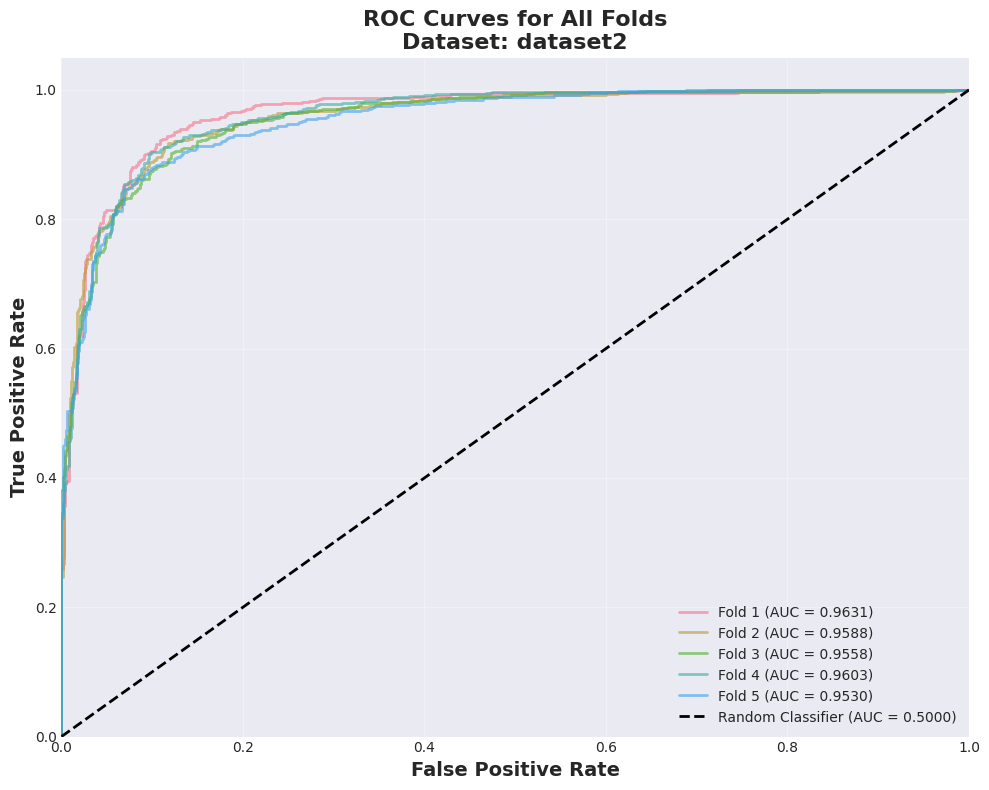

Figure saved as: roc_curves_all_folds_dataset2.png


In [9]:
# Create figure with individual fold ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for each fold
for i, result in enumerate(all_fold_results):
    plt.plot(
        result['fpr'], 
        result['tpr'], 
        alpha=0.6, 
        linewidth=2,
        label=f"Fold {result['fold']} (AUC = {result['auc']:.4f})"
    )

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

# Formatting
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title(f'ROC Curves for All Folds\nDataset: {dataset}', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

# Save figure
plt.savefig(f'roc_curves_all_folds_{dataset}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: roc_curves_all_folds_{dataset}.png")


## Plot Mean ROC Curve with Confidence Interval


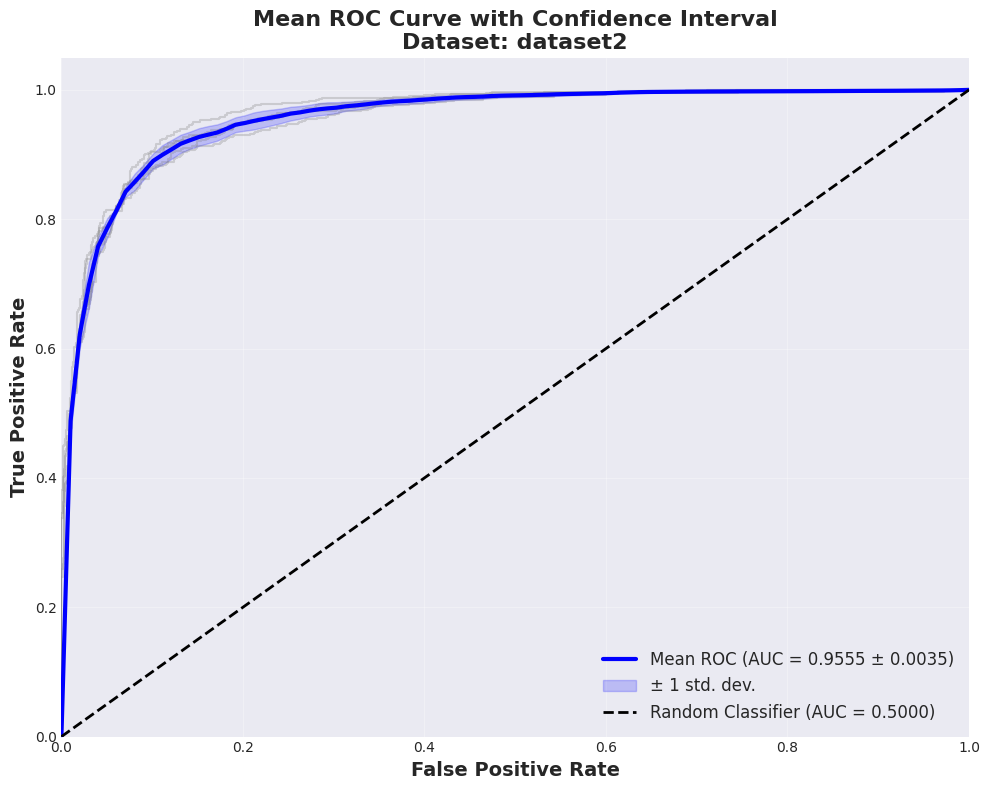

Figure saved as: roc_curve_mean_dataset2.png


In [10]:
# Calculate mean and std of TPR across folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Calculate standard deviation of TPR
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# Create figure with mean ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

# Plot individual fold ROC curves (lighter)
for i, result in enumerate(all_fold_results):
    ax.plot(
        result['fpr'], 
        result['tpr'], 
        alpha=0.3, 
        linewidth=1.5,
        color='gray'
    )

# Plot mean ROC curve
ax.plot(
    mean_fpr, 
    mean_tpr, 
    color='blue',
    linewidth=3,
    label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})'
)

# Plot confidence interval
ax.fill_between(
    mean_fpr, 
    tprs_lower, 
    tprs_upper, 
    color='blue', 
    alpha=0.2,
    label='± 1 std. dev.'
)

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

# Formatting
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title(f'Mean ROC Curve with Confidence Interval\nDataset: {dataset}', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()

# Save figure
plt.savefig(f'roc_curve_mean_{dataset}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: roc_curve_mean_{dataset}.png")


## Summary Statistics


In [11]:
# Create a summary table
summary_data = {
    'Fold': [f"Fold {i+1}" for i in range(config.TOTAL_FOLDS)] + ['Mean ± Std'],
    'AUC': [f"{auc_val:.4f}" for auc_val in aucs] + [f"{mean_auc:.4f} ± {std_auc:.4f}"]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*50)
print("AUC-ROC Summary Across All Folds")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

# Save summary to CSV
summary_df.to_csv(f'auc_roc_summary_{dataset}.csv', index=False)
print(f"\nSummary saved as: auc_roc_summary_{dataset}.csv")



AUC-ROC Summary Across All Folds
      Fold             AUC
    Fold 1          0.9631
    Fold 2          0.9588
    Fold 3          0.9558
    Fold 4          0.9603
    Fold 5          0.9530
Mean ± Std 0.9555 ± 0.0035

Summary saved as: auc_roc_summary_dataset2.csv


## Combined Visualization: All Folds + Mean


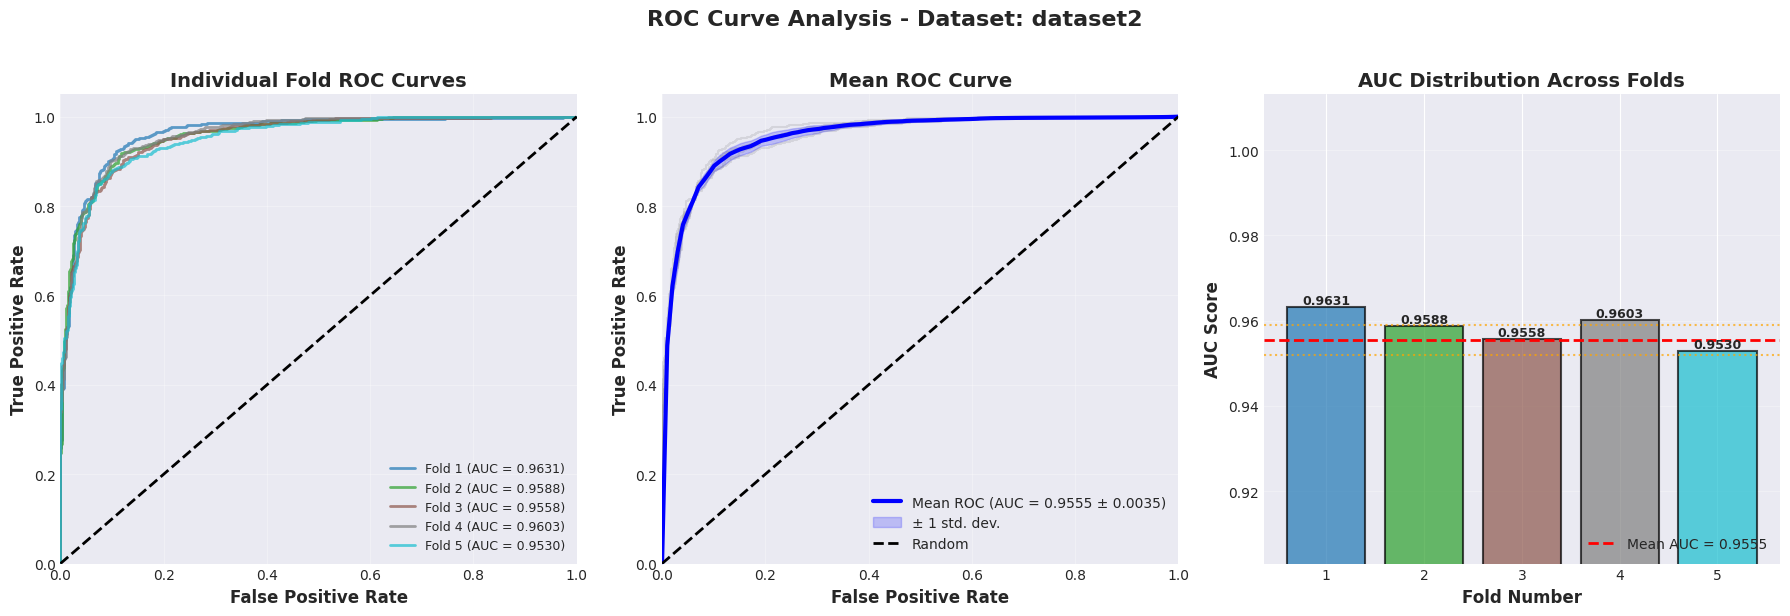

Comprehensive figure saved as: roc_comprehensive_analysis_dataset2.png


In [12]:
# Create a comprehensive figure with subplots
fig = plt.figure(figsize=(18, 6))

# Subplot 1: All individual fold ROC curves
ax1 = plt.subplot(1, 3, 1)
colors = plt.cm.tab10(np.linspace(0, 1, config.TOTAL_FOLDS))
for i, result in enumerate(all_fold_results):
    ax1.plot(
        result['fpr'], 
        result['tpr'], 
        alpha=0.7, 
        linewidth=2,
        color=colors[i],
        label=f"Fold {result['fold']} (AUC = {result['auc']:.4f})"
    )
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('Individual Fold ROC Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# Subplot 2: Mean ROC curve with confidence interval
ax2 = plt.subplot(1, 3, 2)
for i, result in enumerate(all_fold_results):
    ax2.plot(result['fpr'], result['tpr'], alpha=0.2, linewidth=1.5, color='gray')
ax2.plot(mean_fpr, mean_tpr, color='blue', linewidth=3,
         label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})')
ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2,
                 label='± 1 std. dev.')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('Mean ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

# Subplot 3: AUC distribution across folds
ax3 = plt.subplot(1, 3, 3)
fold_numbers = [i+1 for i in range(config.TOTAL_FOLDS)]
bars = ax3.bar(fold_numbers, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.axhline(y=mean_auc, color='red', linestyle='--', linewidth=2, label=f'Mean AUC = {mean_auc:.4f}')
ax3.axhline(y=mean_auc + std_auc, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.axhline(y=mean_auc - std_auc, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax3.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('AUC Distribution Across Folds', fontsize=14, fontweight='bold')
ax3.set_xticks(fold_numbers)
ax3.set_ylim([min(aucs) - 0.05, max(aucs) + 0.05])
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, auc_val) in enumerate(zip(bars, aucs)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{auc_val:.4f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle(f'ROC Curve Analysis - Dataset: {dataset}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save comprehensive figure
plt.savefig(f'roc_comprehensive_analysis_{dataset}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Comprehensive figure saved as: roc_comprehensive_analysis_{dataset}.png")


## Analysis Complete

This notebook has successfully:
1. Trained and tested the joint VGAE-LDAGM model for 5-fold cross-validation
2. Collected ROC curve data for each fold
3. Generated individual fold ROC curves
4. Computed and plotted the mean ROC curve with confidence intervals
5. Created a comprehensive visualization showing all aspects of model performance
6. Saved all figures and summary statistics

Generated files:
- `roc_curves_all_folds_{dataset}.png`: Individual fold ROC curves
- `roc_curve_mean_{dataset}.png`: Mean ROC curve with confidence interval
- `roc_comprehensive_analysis_{dataset}.png`: Complete analysis dashboard
- `auc_roc_summary_{dataset}.csv`: Summary statistics table
